# Assignment: Cointegration Pairs Strategy Model 








<div class="alert alert-block alert-info">
<b>Tip :</b>Before reading the code, pls read first the README file for background informatio. .
</div>

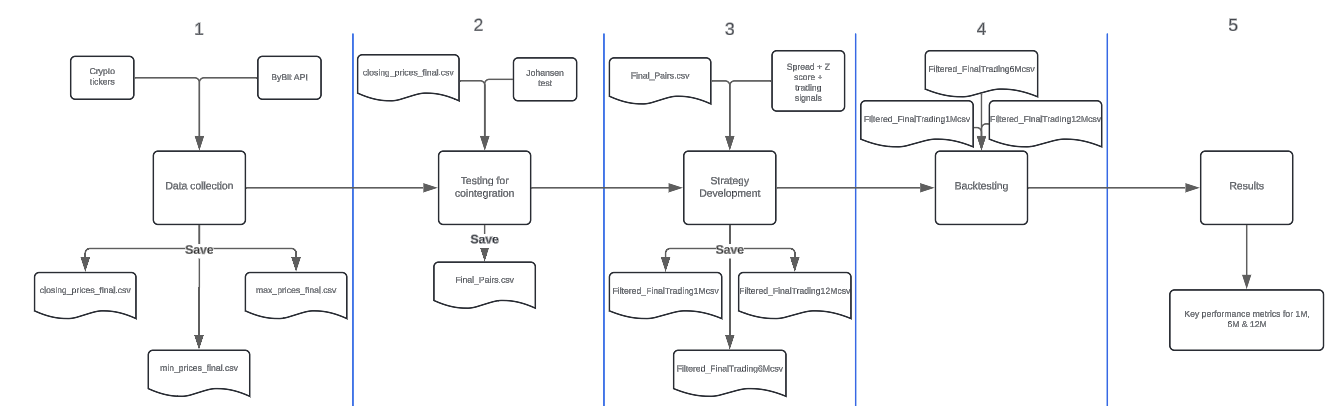

## Table of Contents 







### 1. Data Collection

### 2. Testing for Cointegration

### 3. Strategy Development

### 4. Backtesting

### 5. Results

---------------------------------------------------------------

# 1. Data Collection

In [ ]:
# Install these packages
!pip install pandas
!pip install pybit
!pip install numpy
!pip install datetime
!pip install time
!pip install backtrader
!pip install ccxt
!pip install matplotlib
!pip install statsmodels

For the data collection part, I make use of the API from ByBit. The data that gets collected is the close, min & max price of the top ≈100 cryptocurrencies by market cap, except of crypto's that are stablecoins, or they don't have an /USDT pair on ByBit. The start data is 2023-06-12 and the end date is 2024-06-12, all the data is collected on the 1 minute interval. The API key + secret are not so secret, since they are from a random subaccount that is not in use.

In [ ]:

# COLLECTING ALL DATA MIN MAX CLOSE ON 1M INTERVAL
import pandas as pd
import ccxt
import time
from datetime import datetime


# Initialize an exchange instance
exchange = ccxt.bybit({
    'apiKey': 'GZtQLv5wNSxUbhT1Oy',  # Replace with your actual API key
    'secret': '0q4jddnvQO78reL3ONHHvL7Ca3A8FMXuTwSg',  # Replace with your actual API secret
})


# Initialize the Cryptocurrencies we want to collect
tickers = [
    'BTC', 'ETH', 'BNB', 'SOL', 'XRP', 'TON', 'DOGE', 'ADA', 'TRX', 'AVAX',
    'SHIB', 'DOT', 'LINK', 'BCH', 'NEAR', 'LTC', 'MATIC', 'UNI', 'KAS',
    'PEPE', 'ICP', 'ETC', 'FET', 'APT', 'XLM', 'STX', 'HBAR', 'RNDR',
    'ATOM', 'FIL', 'MNT', 'ARB', 'MKR', 'IMX', 'OP', 'SUI',
    'INJ', 'GRT', 'NOT', 'BONK', 'WIF', 'LDO', 'AR', 'AAVE', 'THETA',
    'FLOKI', 'ONDO', 'FTM', 'TIA', 'RUNE', 'JASMY', 'ALGO', 'BRETT', 'PYTH', 'JUP',
    'CORE', 'EGLD', 'SEI', 'KCS', 'QNT', 'ENS', 'FLOW', 'FLR', 'STRK',
    'AXS', 'EOS', 'DYDX', 'BTT', 'XTZ', 'BEAM', 'GALA', 'SAND',
    'ENA', 'ORDI', 'NEXO', 'SAFE', 'MANA', 'MOG', 'PENDLE', 'XEC',
    'CHZ', 'SAFE', 'ZK', 'MINA', 'SNX', 'ROSE', 'KLAY', 'BOME', '1INCH', 'HNT', 'CAKE', 'W',
    'WEMIX', 'AXL', 'WLD', 'AIOZ', 'XDC', 'APE', 'KAVA', 'KSM', 'ZIL', 'LUNA', 'HOT', 'GAL', 'SUSHI'
]


# Time period from June 12, 2023, to June 12, 2024
start_date = '2023-06-12T00:00:00Z'
end_date = '2024-06-12T23:59:59Z'


# Convert the dates to timestamps
start_timestamp = exchange.parse8601(start_date)
end_timestamp = exchange.parse8601(end_date)


def fetch_prices(symbol, exchange, start_timestamp, end_timestamp):
    closing_prices = []
    min_prices = []
    max_prices = []
    timestamps = []
    since = start_timestamp
    while since <= end_timestamp:
        try:
            ohlcv = exchange.fetch_ohlcv(symbol, '1m', since, limit=200)
            if len(ohlcv) == 0:
                break
            for entry in ohlcv:
                timestamps.append(pd.to_datetime(entry[0], unit='ms'))
                closing_prices.append(entry[4])  # Append the closing price
                min_prices.append(entry[3])  # Append the minimum price
                max_prices.append(entry[2])  # Append the maximum price
            since = ohlcv[-1][0] + 60000  # Move to the next timestamp
            # Respect rate limits
            time.sleep(exchange.rateLimit / 1000)
        except ccxt.NetworkError as e:
            print(f"Network error: {str(e)}. Retrying...")
            time.sleep(5)  # Wait a bit before retrying
        except ccxt.ExchangeError as e:
            print(f"Exchange error: {str(e)}")
            break
        except Exception as e:
            print(f"Unknown error: {str(e)}")
            break
    # Fill missing data with zeros
    if len(closing_prices) == 0 or len(timestamps) == 0:
        closing_prices = [0] * ((end_timestamp - start_timestamp) // 60000)
        min_prices = [0] * ((end_timestamp - start_timestamp) // 60000)
        max_prices = [0] * ((end_timestamp - start_timestamp) // 60000)
        timestamps = [pd.to_datetime(start_timestamp + i * 60000, unit='ms') for i in range(len(closing_prices))]
    return timestamps, closing_prices, min_prices, max_prices


# Initialize a dictionary to hold the data
data = {ticker: {'close': [], 'min': [], 'max': []} for ticker in tickers}


# Fetch and store the data
all_timestamps = set()  # To store all unique timestamps
save_interval = 10  # Save data every 10 tickers
for index, ticker in enumerate(tickers):
    symbol = f"{ticker}/USDT"
    print(f"Fetching data for {symbol}...")
    timestamps, closing_prices, min_prices, max_prices = fetch_prices(symbol, exchange, start_timestamp, end_timestamp)
    if closing_prices and timestamps and min_prices and max_prices:
        data[ticker]['close'] = closing_prices
        data[ticker]['min'] = min_prices
        data[ticker]['max'] = max_prices
        all_timestamps.update(timestamps)
    else:
        print(f"No data fetched for {symbol}")


    # Save periodically
    if (index + 1) % save_interval == 0 or ticker == tickers[-1]:
        if len(data) > 0 and len(all_timestamps) > 0:
            combined_df_close = pd.DataFrame(index=sorted(all_timestamps))
            combined_df_min = pd.DataFrame(index=sorted(all_timestamps))
            combined_df_max = pd.DataFrame(index=sorted(all_timestamps))
            for t in tickers:
                if t in data and len(data[t]['close']) == len(timestamps):
                    combined_df_close[t] = pd.Series(data[t]['close'], index=timestamps)
                    combined_df_min[t] = pd.Series(data[t]['min'], index=timestamps)
                    combined_df_max[t] = pd.Series(data[t]['max'], index=timestamps)
            combined_df_close.to_csv(f'closing_prices_partial_{index + 1}.csv')
            combined_df_min.to_csv(f'min_prices_partial_{index + 1}.csv')
            combined_df_max.to_csv(f'max_prices_partial_{index + 1}.csv')
            print(f"Partial data saved for {ticker}")


# Final save after completion
if len(data) > 0 and len(all_timestamps) > 0:
    combined_df_close = pd.DataFrame(index=sorted(all_timestamps))
    combined_df_min = pd.DataFrame(index=sorted(all_timestamps))
    combined_df_max = pd.DataFrame(index=sorted(all_timestamps))
    for t in tickers:
        if t in data and len(data[t]['close']) == len(timestamps):
            combined_df_close[t] = pd.Series(data[t]['close'], index=timestamps)
            combined_df_min[t] = pd.Series(data[t]['min'], index=timestamps)
            combined_df_max[t] = pd.Series(data[t]['max'], index=timestamps)
    combined_df_close.to_csv('closing_prices_final.csv')
    combined_df_min.to_csv('min_prices_final.csv')
    combined_df_max.to_csv('max_prices_final.csv')
    print("Data fetching complete and saved to 'closing_prices_final.csv', 'min_prices_final.csv', and 'max_prices_final.csv'")
else:
    print("No data fetched, no file saved")

The CSV's : 'closing_prices_final.csv', 'min_prices_final.csv', and 'max_prices_final.csv' can be found in the folder.

# 2. Testing for Cointegration

To test for cointegration we make use of the Johansen test and the close price. We will test on 3 different time frames for cointegration, because we also use 3 different timeframes in our trading strategy. The code will start with the 1 month timeframe, then the 6 month timeframe and finally the 12 month timeframe. But before there can be started with tested for cointegration, there will be made a CSV for each timeframe, these can be found again within the folder.

In [ ]:
import pandas as pd

# Load the dataset with 'Unnamed: 0' as the index column
file_path = 'D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\closing_prices_final.csv'
data = pd.read_csv(file_path, index_col='Unnamed: 0', parse_dates=True)

# Create the three separate DataFrames
Y12MonthData = data.copy()
last_6_months = data.loc[data.index >= '2023-12-13']
last_1_month = data.loc[data.index >= '2024-05-13']

# Save the DataFrames to separate CSV files
Y12MonthData.to_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\12MonthData.csv')
last_6_months.to_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\6MonthsData.csv')
last_1_month.to_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\1MonthData.csv')

print("CSV files created successfully.")

Now it is time to test for cointegration on each separate timeframe. There has been made a distinction between the p value of 0.01 and 0.05, this can later on be applied for risk management by using the bot. Since a lower p value means a more significant cointregated relationship, so the stake for a p value <0.01 could be higher than for a P 0.01 > ~ P <0.05. 1 month:

In [ ]:
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Load the cleaned data
file_path = 'D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\1MonthData.csv'
closing_prices_df = pd.read_csv(file_path, index_col=0, parse_dates=True)

# Function to perform Johansen test and get p-values
def johansen_test(df):
    coint_result = coint_johansen(df, 0, 1)
    p_values = coint_result.lr1
    return p_values

# Initialize lists to store results
pairs_0_01 = []
pairs_0_05 = []

# Get all unique pairs
tickers = closing_prices_df.columns
unique_pairs = set()
for i in range(len(tickers)):
    for j in range(i + 1, len(tickers)):
        ticker1 = tickers[i]
        ticker2 = tickers[j]

        # Check if pair has already been considered (both directions)
        pair1 = f"{ticker1}/{ticker2}"
        pair2 = f"{ticker2}/{ticker1}"
        if pair1 in unique_pairs or pair2 in unique_pairs:
            continue

        # Perform Johansen test on prices
        pair_data = closing_prices_df[[ticker1, ticker2]].dropna()
        if len(pair_data) > 0:
            p_values = johansen_test(pair_data)
            min_p_value = min(p_values)

            # Format p-value to five decimal places
            formatted_p_value = f"{min_p_value:.5f}"

            # Store in appropriate list based on significance level
            if min_p_value <= 0.01:
                pairs_0_01.append((pair1, formatted_p_value))
                unique_pairs.add(pair1)
            elif 0.01 < min_p_value <= 0.05:
                pairs_0_05.append((pair1, formatted_p_value))
                unique_pairs.add(pair1)

# Convert results to DataFrames
df_0_01 = pd.DataFrame(pairs_0_01, columns=['Pair', 'P-Value'])
df_0_05 = pd.DataFrame(pairs_0_05, columns=['Pair', 'P-Value'])

# Save results to CSV files
df_0_01.to_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\PC1Months0.01.csv', index=False)
df_0_05.to_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\PC1Months0.05.csv', index=False)

print("Johansen cointegration test results for the last 1 month saved successfully.")


6 Months:

In [ ]:
import pandas as pd
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Load the cleaned data
file_path = 'D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\6MonthsData.csv'
closing_prices_df = pd.read_csv(file_path, index_col=0, parse_dates=True)

# Function to perform Johansen test and get p-values
def johansen_test(df):
    coint_result = coint_johansen(df, 0, 1)
    p_values = coint_result.lr1
    return p_values

# Initialize lists to store results
pairs_0_01 = []
pairs_0_05 = []

# Get all unique pairs
tickers = closing_prices_df.columns
unique_pairs = set()
for i in range(len(tickers)):
    for j in range(i + 1, len(tickers)):
        ticker1 = tickers[i]
        ticker2 = tickers[j]

        # Check if pair has already been considered (both directions)
        pair1 = f"{ticker1}/{ticker2}"
        pair2 = f"{ticker2}/{ticker1}"
        if pair1 in unique_pairs or pair2 in unique_pairs:
            continue

        # Perform Johansen test on prices
        pair_data = closing_prices_df[[ticker1, ticker2]].dropna()
        if len(pair_data) > 0:
            p_values = johansen_test(pair_data)
            min_p_value = min(p_values)

            # Format p-value to five decimal places
            formatted_p_value = f"{min_p_value:.5f}"

            # Store in appropriate list based on significance level
            if min_p_value <= 0.01:
                pairs_0_01.append((pair1, formatted_p_value))
                unique_pairs.add(pair1)
            elif 0.01 < min_p_value <= 0.05:
                pairs_0_05.append((pair1, formatted_p_value))
                unique_pairs.add(pair1)

# Convert results to DataFrames
df_0_01 = pd.DataFrame(pairs_0_01, columns=['Pair', 'P-Value'])
df_0_05 = pd.DataFrame(pairs_0_05, columns=['Pair', 'P-Value'])

# Save results to CSV files
df_0_01.to_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\PC6Months0.01.csv', index=False)
df_0_05.to_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\PC6Months0.05.csv', index=False)

print("Johansen cointegration test results for the last 6 months saved successfully.")


12 Months:

In [ ]:
import pandas as pd
import numpy as np
import sys
sys.path.append('D:/Users/pctim/AppData/Local/Programs/Python/Python312/venv/Lib/site-packages')
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# Load the cleaned data
file_path = 'D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\12MonthData.csv'
closing_prices_df = pd.read_csv(file_path, index_col=0, parse_dates=True)

# Function to perform Johansen test and get p-values
def johansen_test(df):
    coint_result = coint_johansen(df, 0, 1)
    p_values = coint_result.lr1
    return p_values

# Initialize lists to store results
pairs_0_01 = []
pairs_0_05 = []

# Get all unique pairs
tickers = closing_prices_df.columns
unique_pairs = set()
for i in range(len(tickers)):
    for j in range(i + 1, len(tickers)):
        ticker1 = tickers[i]
        ticker2 = tickers[j]

        # Check if pair has already been considered (both directions)
        pair1 = f"{ticker1}/{ticker2}"
        pair2 = f"{ticker2}/{ticker1}"
        if pair1 in unique_pairs or pair2 in unique_pairs:
            continue

        # Perform Johansen test on prices
        pair_data = closing_prices_df[[ticker1, ticker2]].dropna()
        if len(pair_data) > 0:
            p_values = johansen_test(pair_data)
            min_p_value = min(p_values)

            # Format p-value to five decimal places
            formatted_p_value = f"{min_p_value:.5f}"

            # Store in appropriate list based on significance level
            if min_p_value <= 0.01:
                pairs_0_01.append((pair1, formatted_p_value))
                unique_pairs.add(pair1)
            elif 0.01 < min_p_value <= 0.05:
                pairs_0_05.append((pair1, formatted_p_value))
                unique_pairs.add(pair1)

# Convert results to DataFrames
df_0_01 = pd.DataFrame(pairs_0_01, columns=['Pair', 'P-Value'])
df_0_05 = pd.DataFrame(pairs_0_05, columns=['Pair', 'P-Value'])

# Save results to CSV files
df_0_01.to_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\PC12Months0.01.csv', index=False)
df_0_05.to_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\PC12Months0.05.csv', index=False)

print("Cointegration test results saved successfully.")


Now we have all the pairs of cointegrated cryptocurrencies, the duplicate cryptocurrencies will be deleted and the first occurrence will be saved. Example: ADA/ZIL is in the 12 month and in the 1 month CSV as a pair. The 12 month pair will be saved, and the 1 month pair will be deleted. Since it has a cointegrated relationship over 12 months, I want to trade it also on the higher time frame, so there is more safety since the relationship last longer. We could say, why not trade in both the cases? I decided to not do this in case of overtrading a certain pair.  

In [ ]:
import pandas as pd

# Load the CSV files with pairs
pairs_12_months_0_01 = pd.read_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\PC12Months0.01.csv')
pairs_12_months_0_05 = pd.read_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\PC12Months0.05.csv')
pairs_6_months_0_01 = pd.read_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\PC6Months0.01.csv')
pairs_6_months_0_05 = pd.read_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\PC6Months0.05.csv')
pairs_1_month_0_01 = pd.read_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\PC1Months0.01.csv')
pairs_1_month_0_05 = pd.read_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\PC1Months0.05.csv')

# Add a column to identify the dataset
pairs_12_months_0_01['Dataset'] = '12M'
pairs_12_months_0_05['Dataset'] = '12M'
pairs_6_months_0_01['Dataset'] = '6M'
pairs_6_months_0_05['Dataset'] = '6M'
pairs_1_month_0_01['Dataset'] = '1M'
pairs_1_month_0_05['Dataset'] = '1M'

# Combine all pairs into one DataFrame
all_pairs = pd.concat([
    pairs_12_months_0_01, pairs_12_months_0_05,
    pairs_6_months_0_01, pairs_6_months_0_05,
    pairs_1_month_0_01, pairs_1_month_0_05
])

# Correct sorting logic to ensure 12M pairs come first, then 6M, then 1M
all_pairs['Dataset'] = pd.Categorical(all_pairs['Dataset'], categories=['12M', '6M', '1M'], ordered=True)
all_pairs.sort_values(by='Dataset', inplace=True)

# Remove duplicates, keeping the first occurrence (which is from the most comprehensive dataset)
unique_pairs = all_pairs.drop_duplicates(subset=['Pair'])

# Save the results to a CSV file
unique_pairs.to_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\Final_Pairs.csv', index=False)

print("Filtered cointegration pairs saved successfully.")


The Final_Pairs.csv can also be found in the folder.

# 3. Strategy development

Now we have all the pairs sorted, it is time to calculate the spread and Z score, and to set based on this the corresponding signals. 
Long the spread (long Crypto X and short Crypto Y) whenever the Z-score is below –2.
Short the spread (short Crypto X and long Crypto Y) whenever the Z-score is above 2.
Exit positions when the Z-score hits zero (mean).
Stop-loss of the positions when the spread reaches a Z-score of ± 
We start again with the 1 Month, all the CSV's can be found in the folder.4.


In [ ]:
import pandas as pd

# Load the relevant CSV files
final_pairs = pd.read_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\Final_Pairs.csv')
max_prices = pd.read_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\max_prices_final.csv', index_col=0)
min_prices = pd.read_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\min_prices_final.csv', index_col=0)

# Define the date range for the last 6 months
start_date = '2024-5-12'
end_date = '2024-06-12'

# Filter pairs by '1M' dataset
filtered_pairs_1M = final_pairs[final_pairs['Dataset'] == '1M']

# Save the filtered pairs to a separate CSV file
filtered_pairs_1M.to_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\Final_Pairs_1M.csv', index=False)

print("Filtered pairs for '1M' dataset saved to Final_Pairs_1M.csv")

# Load the filtered pairs for '1M' dataset
filtered_pairs_1M = pd.read_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\Final_Pairs_1M.csv')

# Extract unique cryptos from all pairs
unique_cryptos = set()
for pair in filtered_pairs_1M['Pair']:  # Take all pairs
    asset1, asset2 = pair.split('/')
    unique_cryptos.update([asset1, asset2])

# Create DataFrame for min and max prices
prices_data = {}
for crypto in unique_cryptos:
    prices_data[f'{crypto}_MIN'] = min_prices[crypto]
    prices_data[f'{crypto}_MAX'] = max_prices[crypto]

# Initialize the DataFrame with min and max prices
prices_df = pd.DataFrame(prices_data, index=max_prices.index)

# Function to calculate normalized spread (Z-score)
def calculate_normalized_spread(spread):
    return (spread - spread.mean()) / spread.std()  # Z-score normalization

# Process pairs in chunks to manage memory usage
chunk_size = 10
num_pairs = len(filtered_pairs_1M['Pair'])
for start in range(0, num_pairs, chunk_size):
    end = start + chunk_size
    chunk_pairs = filtered_pairs_1M['Pair'][start:end]
    
    spreads_data = {}
    signals_data = {}
    for pair in chunk_pairs:
        asset1, asset2 = pair.split('/')
        spread_max_max = max_prices[asset1] - max_prices[asset2]
        spread_max_min = max_prices[asset1] - min_prices[asset2]
        spread_min_max = min_prices[asset1] - max_prices[asset2]
        spread_min_min = min_prices[asset1] - min_prices[asset2]

        spreads_data[f'zscore_{pair}_max_max'] = calculate_normalized_spread(spread_max_max)
        spreads_data[f'zscore_{pair}_max_min'] = calculate_normalized_spread(spread_max_min)
        spreads_data[f'zscore_{pair}_min_max'] = calculate_normalized_spread(spread_min_max)
        spreads_data[f'zscore_{pair}_min_min'] = calculate_normalized_spread(spread_min_min)
        signals_data[f'signal_{pair}'] = ['None'] * len(max_prices)
        print(f"Calculated spreads for pair {pair}")

    # Add spread and signal columns to prices_df
    prices_df = pd.concat([prices_df, pd.DataFrame(spreads_data, index=max_prices.index)], axis=1)
    prices_df = pd.concat([prices_df, pd.DataFrame(signals_data, index=max_prices.index)], axis=1)
    
    # Save the DataFrame after processing each chunk
    prices_df.to_csv(f'D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\Interim_FinalTradingCSV_{start+chunk_size}.csv', index=True)
    print(f"Saved interim DataFrame after processing pairs {start+1} to {end}")

# Function to calculate the trading signals for each pair
def calculate_signals(df, pairs):
    for count, pair in enumerate(pairs):
        signal_col = f'signal_{pair}'
        position_open = False  # Tracks if a position is currently open
        opened_at = None  # Keeps track of the Z-score when the position was opened

        # Iterate through Z-scores to find signals
        for i in range(1, len(df)):
            zscores = [
                df.iloc[i][f'zscore_{pair}_max_max'],
                df.iloc[i][f'zscore_{pair}_max_min'],
                df.iloc[i][f'zscore_{pair}_min_max'],
                df.iloc[i][f'zscore_{pair}_min_min']
            ]
            prev_zscores = [
                df.iloc[i-1][f'zscore_{pair}_max_max'],
                df.iloc[i-1][f'zscore_{pair}_max_min'],
                df.iloc[i-1][f'zscore_{pair}_min_max'],
                df.iloc[i-1][f'zscore_{pair}_min_min']
            ] if i > 0 else [None, None, None, None]

            # Only open positions when any Z-score crosses 2 or -2
            if not position_open:
                if any(prev is not None and prev < 2 and curr >= 2 for prev, curr in zip(prev_zscores, zscores)):
                    df.at[df.index[i], signal_col] = f'Sell {pair.split("/")[0]}, Buy {pair.split("/")[1]}'
                    position_open = True
                    opened_at = [curr for prev, curr in zip(prev_zscores, zscores) if prev is not None and prev < 2 and curr >= 2][0]
                elif any(prev is not None and prev > -2 and curr <= -2 for prev, curr in zip(prev_zscores, zscores)):
                    df.at[df.index[i], signal_col] = f'Buy {pair.split("/")[0]}, Sell {pair.split("/")[1]}'
                    position_open = True
                    opened_at = [curr for prev, curr in zip(prev_zscores, zscores) if prev is not None and prev > -2 and curr <= -2][0]
            # Close position logic
            elif position_open:
                if any((opened_at > 0 and curr <= 0) or (opened_at < 0 and curr >= 0) or curr >= 4 or curr <= -4 for curr in zscores):
                    df.at[df.index[i], signal_col] = 'Close Positions'
                    position_open = False
                    opened_at = None
                else:
                    df.at[df.index[i], signal_col] = 'Active'
        
        print(f"Processed signals for pair {pair}")
        if (count + 1) % 5 == 0:
            df.to_csv(f'D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\Interim_Signals_FinalTradingCSV_{count+1}.csv', index=True)
            print(f"Saved interim DataFrame after processing signals for {count+1} pairs")
    return df

# Apply the function to generate signals
prices_df = calculate_signals(prices_df, filtered_pairs_1M['Pair'])  # Take all pairs

# Ensure all NaN values are filled with 'None'
for pair in filtered_pairs_1M['Pair']:
    prices_df[f'signal_{pair}'] = prices_df[f'signal_{pair}'].fillna('None')

# Save the final DataFrame to CSV
prices_df.to_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\FinalTrading1MCSV.csv', index=True)

print("FinalTrading1MCSV.csv saved successfully.")






6 Months:

In [ ]:
import pandas as pd

# Define the date range for the last 6 months
start_date = '2023-12-12'
end_date = '2024-06-12'

# Load the relevant CSV files
final_pairs = pd.read_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\Final_Pairs.csv')

# Filter pairs with '6M' in the Dataset column
filtered_pairs_6M = final_pairs[final_pairs['Dataset'] == '6M']

# Save the filtered pairs to a new CSV file
filtered_pairs_6M.to_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\Final_Pairs_6M.csv', index=False)
print("Filtered pairs for '6M' dataset saved successfully.")

# Load the filtered pairs for '6M' dataset
filtered_pairs_6M = pd.read_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\Final_Pairs_6M.csv')

# Load the min and max prices, filtering by date range
max_prices = pd.read_csv(
    'D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\max_prices_final.csv', 
    index_col=0, parse_dates=True
).loc[start_date:end_date]

min_prices = pd.read_csv(
    'D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\min_prices_final.csv', 
    index_col=0, parse_dates=True
).loc[start_date:end_date]

# Extract unique cryptos from all pairs
unique_cryptos = set()
for pair in filtered_pairs_6M['Pair']:  # Take all pairs
    asset1, asset2 = pair.split('/')
    unique_cryptos.update([asset1, asset2])

# Create DataFrame for min and max prices
prices_data = {}
for crypto in unique_cryptos:
    prices_data[f'{crypto}_MIN'] = min_prices[crypto]
    prices_data[f'{crypto}_MAX'] = max_prices[crypto]

# Initialize the DataFrame with min and max prices
prices_df = pd.DataFrame(prices_data, index=max_prices.index)

# Function to calculate normalized spread (Z-score)
def calculate_normalized_spread(spread):
    return (spread - spread.mean()) / spread.std()  # Z-score normalization

# Process pairs in chunks to manage memory usage
chunk_size = 5
num_pairs = len(filtered_pairs_6M['Pair'])
for start in range(0, num_pairs, chunk_size):
    end = start + chunk_size
    chunk_pairs = filtered_pairs_6M['Pair'][start:end]
    
    spreads_data = {}
    signals_data = {}
    for pair in chunk_pairs:
        asset1, asset2 = pair.split('/')
        spread_max_max = max_prices[asset1] - max_prices[asset2]
        spread_max_min = max_prices[asset1] - min_prices[asset2]
        spread_min_max = min_prices[asset1] - max_prices[asset2]
        spread_min_min = min_prices[asset1] - min_prices[asset2]

        spreads_data[f'zscore_{pair}_max_max'] = calculate_normalized_spread(spread_max_max)
        spreads_data[f'zscore_{pair}_max_min'] = calculate_normalized_spread(spread_max_min)
        spreads_data[f'zscore_{pair}_min_max'] = calculate_normalized_spread(spread_min_max)
        spreads_data[f'zscore_{pair}_min_min'] = calculate_normalized_spread(spread_min_min)
        signals_data[f'signal_{pair}'] = ['None'] * len(max_prices)
        print(f"Calculated spreads for pair {pair}")

    # Add spread and signal columns to prices_df
    prices_df = pd.concat([prices_df, pd.DataFrame(spreads_data, index=max_prices.index)], axis=1)
    prices_df = pd.concat([prices_df, pd.DataFrame(signals_data, index=max_prices.index)], axis=1)
    
    # Save the DataFrame after processing each chunk
    prices_df.to_csv(f'D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\Interim_FinalTradingCSV_{start+chunk_size}.csv', index=True)
    print(f"Saved interim DataFrame after processing pairs {start+1} to {end}")

# Function to calculate the trading signals for each pair
def calculate_signals(df, pairs):
    for count, pair in enumerate(pairs):
        signal_col = f'signal_{pair}'
        position_open = False  # Tracks if a position is currently open
        opened_at = None  # Keeps track of the Z-score when the position was opened

        # Iterate through Z-scores to find signals
        for i in range(1, len(df)):
            zscores = [
                df.iloc[i][f'zscore_{pair}_max_max'],
                df.iloc[i][f'zscore_{pair}_max_min'],
                df.iloc[i][f'zscore_{pair}_min_max'],
                df.iloc[i][f'zscore_{pair}_min_min']
            ]
            prev_zscores = [
                df.iloc[i-1][f'zscore_{pair}_max_max'],
                df.iloc[i-1][f'zscore_{pair}_max_min'],
                df.iloc[i-1][f'zscore_{pair}_min_max'],
                df.iloc[i-1][f'zscore_{pair}_min_min']
            ] if i > 0 else [None, None, None, None]

            # Only open positions when any Z-score crosses 2 or -2
            if not position_open:
                if any(prev is not None and prev < 2 and curr >= 2 for prev, curr in zip(prev_zscores, zscores)):
                    df.at[df.index[i], signal_col] = f'Sell {pair.split("/")[0]}, Buy {pair.split("/")[1]}'
                    position_open = True
                    opened_at = [curr for prev, curr in zip(prev_zscores, zscores) if prev is not None and prev < 2 and curr >= 2][0]
                elif any(prev is not None and prev > -2 and curr <= -2 for prev, curr in zip(prev_zscores, zscores)):
                    df.at[df.index[i], signal_col] = f'Buy {pair.split("/")[0]}, Sell {pair.split("/")[1]}'
                    position_open = True
                    opened_at = [curr for prev, curr in zip(prev_zscores, zscores) if prev is not None and prev > -2 and curr <= -2][0]
            # Close position logic
            elif position_open:
                if any((opened_at > 0 and curr <= 0) or (opened_at < 0 and curr >= 0) or curr >= 4 or curr <= -4 for curr in zscores):
                    df.at[df.index[i], signal_col] = 'Close Positions'
                    position_open = False
                    opened_at = None
                else:
                    df.at[df.index[i], signal_col] = 'Active'
        
        print(f"Processed signals for pair {pair}")
        if (count + 1) % 5 == 0:
            df.to_csv(f'D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\Interim_Signals_6MFinalTradingCSV_{count+1}.csv', index=True)
            print(f"Saved interim DataFrame after processing signals for {count+1} pairs")
    return df

# Apply the function to generate signals
prices_df = calculate_signals(prices_df, filtered_pairs_6M['Pair'])  # Take all pairs

# Ensure all NaN values are filled with 'None'
for pair in filtered_pairs_6M['Pair']:
    prices_df[f'signal_{pair}'] = prices_df[f'signal_{pair}'].fillna('None')

# Save the final DataFrame to CSV
prices_df.to_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\Filtered_FinalTrading6MCSV.csv', index=True)

print("Filtered_FinalTrading6MCSV.csv saved successfully.")


import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random

# Path to the files
file_path = 'D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\FinalTrading6MCSV.csv'
pairs_file_path = 'D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\Final_Pairs_6M.csv'

# Extract the pairs
filtered_pairs_6M = pd.read_csv(pairs_file_path)
all_pairs = filtered_pairs_6M['Pair'].tolist()

# Select 5 random pairs
random_pairs = random.sample(all_pairs, 5)

# Define the date range for the last 6 months
start_date = '2023-12-12'
end_date = '2024-06-12'

# Function to plot Z-scores and signals for a pair
def plot_pair_zscores_signals(df, pair):
    asset1, asset2 = pair.split('/')
    zscore_columns = [
        f'zscore_{pair}_max_max',
        f'zscore_{pair}_max_min',
        f'zscore_{pair}_min_max',
        f'zscore_{pair}_min_min'
    ]
    signal_column = f'signal_{pair}'

    plt.figure(figsize=(12, 6))
    
    for col in zscore_columns:
        if col in df.columns:
            plt.plot(df.index, df[col], label=col)

    # Plot the signals
    if signal_column in df.columns:
        buy_signals = df[df[signal_column].str.startswith('Buy', na=False)]
        sell_signals = df[df[signal_column].str.startswith('Sell', na=False)]
        close_signals = df[df[signal_column] == 'Close Positions']

        plt.scatter(buy_signals.index, buy_signals[zscore_columns[0]], color='blue', marker='^', label='Buy Signal')
        plt.scatter(sell_signals.index, sell_signals[zscore_columns[0]], color='red', marker='v', label='Sell Signal')
        plt.scatter(close_signals.index, close_signals[zscore_columns[0]], color='black', marker='o', label='Close Signal')

        # Add text labels for each signal
        for i, row in buy_signals.iterrows():
            plt.text(i, row[zscore_columns[0]] - 0.2, f'Buy {asset1}, Sell {asset2}', color='blue', fontsize=14, ha='center', va='top')
        for i, row in sell_signals.iterrows():
            plt.text(i, row[zscore_columns[0]] + 0.2, f'Sell {asset1}, Buy {asset2}', color='red', fontsize=14, ha='center', va='bottom')
        for i, row in close_signals.iterrows():
            plt.text(i, row[zscore_columns[0]] + 0.2, 'Close', color='black', fontsize=14, ha='center', va='bottom')

    plt.axhline(y=0, color='green', linestyle='-', linewidth=1)
    plt.axhline(y=2, color='blue', linestyle='--', linewidth=1)
    plt.axhline(y=-2, color='blue', linestyle='--', linewidth=1)
    plt.axhline(y=4, color='red', linestyle='--', linewidth=1)
    plt.axhline(y=-4, color='red', linestyle='--', linewidth=1)

    plt.title(f'Z-score and Trading Signals for {pair}', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Z-score', fontsize=14)
    plt.ylim(-5, 5)
    plt.legend()
    plt.grid(True)

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Read the entire CSV file into a DataFrame
final_trading_df = pd.read_csv(file_path, parse_dates=True, index_col=0)

# Filter the DataFrame to include only the data within the specified date range
final_trading_df = final_trading_df.loc[start_date:end_date]

# Plot Z-scores and signals for the 5 random pairs
for pair in random_pairs:
    plot_pair_zscores_signals(final_trading_df, pair)



12 Months:

In [ ]:
import pandas as pd

# Load the relevant CSV files
final_pairs = pd.read_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\Final_Pairs.csv')
max_prices = pd.read_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\max_prices_final.csv', index_col=0)
min_prices = pd.read_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\min_prices_final.csv', index_col=0)

# Filter pairs by '12M' dataset
filtered_pairs_12M = final_pairs[final_pairs['Dataset'] == '12M']

# Save the filtered pairs to a separate CSV file
filtered_pairs_12M.to_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\Final_Pairs_12M.csv', index=False)

print("Filtered pairs for '12M' dataset saved to Final_Pairs_12M.csv")


import pandas as pd

# Load the filtered pairs for '12M' dataset
filtered_pairs_12M = pd.read_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\Final_Pairs_12M.csv')

# Load the min and max prices
max_prices = pd.read_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\max_prices_final.csv', index_col=0)
min_prices = pd.read_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\min_prices_final.csv', index_col=0)

# Extract unique cryptos from all pairs
unique_cryptos = set()
for pair in filtered_pairs_12M['Pair']:  # Take all pairs
    asset1, asset2 = pair.split('/')
    unique_cryptos.update([asset1, asset2])

# Create DataFrame for min and max prices
prices_data = {}
for crypto in unique_cryptos:
    prices_data[f'{crypto}_MIN'] = min_prices[crypto]
    prices_data[f'{crypto}_MAX'] = max_prices[crypto]

# Initialize the DataFrame with min and max prices
prices_df = pd.DataFrame(prices_data, index=max_prices.index)

# Function to calculate normalized spread (Z-score)
def calculate_normalized_spread(spread):
    return (spread - spread.mean()) / spread.std()  # Z-score normalization

# Process pairs in chunks to manage memory usage
chunk_size = 10
num_pairs = len(filtered_pairs_12M['Pair'])
for start in range(0, num_pairs, chunk_size):
    end = start + chunk_size
    chunk_pairs = filtered_pairs_12M['Pair'][start:end]
    
    spreads_data = {}
    signals_data = {}
    for pair in chunk_pairs:
        asset1, asset2 = pair.split('/')
        spread_max_max = max_prices[asset1] - max_prices[asset2]
        spread_max_min = max_prices[asset1] - min_prices[asset2]
        spread_min_max = min_prices[asset1] - max_prices[asset2]
        spread_min_min = min_prices[asset1] - min_prices[asset2]

        spreads_data[f'zscore_{pair}_max_max'] = calculate_normalized_spread(spread_max_max)
        spreads_data[f'zscore_{pair}_max_min'] = calculate_normalized_spread(spread_max_min)
        spreads_data[f'zscore_{pair}_min_max'] = calculate_normalized_spread(spread_min_max)
        spreads_data[f'zscore_{pair}_min_min'] = calculate_normalized_spread(spread_min_min)
        signals_data[f'signal_{pair}'] = ['None'] * len(max_prices)
        print(f"Calculated spreads for pair {pair}")

    # Add spread and signal columns to prices_df
    prices_df = pd.concat([prices_df, pd.DataFrame(spreads_data, index=max_prices.index)], axis=1)
    prices_df = pd.concat([prices_df, pd.DataFrame(signals_data, index=max_prices.index)], axis=1)
    
    # Save the DataFrame after processing each chunk
    prices_df.to_csv(f'D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\Interim_FinalTradingCSV_{start+chunk_size}.csv', index=True)
    print(f"Saved interim DataFrame after processing pairs {start+1} to {end}")

# Function to calculate the trading signals for each pair
def calculate_signals(df, pairs):
    for count, pair in enumerate(pairs):
        signal_col = f'signal_{pair}'
        position_open = False  # Tracks if a position is currently open
        opened_at = None  # Keeps track of the Z-score when the position was opened

        # Iterate through Z-scores to find signals
        for i in range(1, len(df)):
            zscores = [
                df.iloc[i][f'zscore_{pair}_max_max'],
                df.iloc[i][f'zscore_{pair}_max_min'],
                df.iloc[i][f'zscore_{pair}_min_max'],
                df.iloc[i][f'zscore_{pair}_min_min']
            ]
            prev_zscores = [
                df.iloc[i-1][f'zscore_{pair}_max_max'],
                df.iloc[i-1][f'zscore_{pair}_max_min'],
                df.iloc[i-1][f'zscore_{pair}_min_max'],
                df.iloc[i-1][f'zscore_{pair}_min_min']
            ] if i > 0 else [None, None, None, None]

            # Only open positions when any Z-score crosses 2 or -2
            if not position_open:
                if any(prev is not None and prev < 2 and curr >= 2 for prev, curr in zip(prev_zscores, zscores)):
                    df.at[df.index[i], signal_col] = f'Sell {pair.split("/")[0]}, Buy {pair.split("/")[1]}'
                    position_open = True
                    opened_at = [curr for prev, curr in zip(prev_zscores, zscores) if prev is not None and prev < 2 and curr >= 2][0]
                elif any(prev is not None and prev > -2 and curr <= -2 for prev, curr in zip(prev_zscores, zscores)):
                    df.at[df.index[i], signal_col] = f'Buy {pair.split("/")[0]}, Sell {pair.split("/")[1]}'
                    position_open = True
                    opened_at = [curr for prev, curr in zip(prev_zscores, zscores) if prev is not None and prev > -2 and curr <= -2][0]
            # Close position logic
            elif position_open:
                if any((opened_at > 0 and curr <= 0) or (opened_at < 0 and curr >= 0) or curr >= 4 or curr <= -4 for curr in zscores):
                    df.at[df.index[i], signal_col] = 'Close Positions'
                    position_open = False
                    opened_at = None
                else:
                    df.at[df.index[i], signal_col] = 'Active'
        
        print(f"Processed signals for pair {pair}")
        if (count + 1) % 5 == 0:
            df.to_csv(f'D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\Interim_Signals_FinalTradingCSV_{count+1}.csv', index=True)
            print(f"Saved interim DataFrame after processing signals for {count+1} pairs")
    return df

# Apply the function to generate signals
prices_df = calculate_signals(prices_df, filtered_pairs_12M['Pair'])  # Take all pairs

# Ensure all NaN values are filled with 'None'
for pair in filtered_pairs_12M['Pair']:
    prices_df[f'signal_{pair}'] = prices_df[f'signal_{pair}'].fillna('None')

# Save the final DataFrame to CSV
prices_df.to_csv('D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\FinalTrading12MCSV.csv', index=True)

print("FinalTrading12MCSV.csv saved successfully")


import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import random

# Path to the files
file_path = 'D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\FinalTrading12MCSV.csv'
pairs_file_path = 'D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\Final_Pairs_12M.csv'

# Define the chunk size
chunk_size = 50000

# Extract the pairs
filtered_pairs_12M = pd.read_csv(pairs_file_path)
all_pairs = filtered_pairs_12M['Pair'].tolist()

# Select 5 random pairs
random_pairs = random.sample(all_pairs, 5)

# Function to plot Z-scores and signals for a pair
def plot_pair_zscores_signals(df, pair):
    asset1, asset2 = pair.split('/')
    zscore_columns = [
        f'zscore_{pair}_max_max',
        f'zscore_{pair}_max_min',
        f'zscore_{pair}_min_max',
        f'zscore_{pair}_min_min'
    ]
    signal_column = f'signal_{pair}'

    plt.figure(figsize=(12, 6))
    
    for col in zscore_columns:
        if col in df.columns:
            plt.plot(df.index, df[col], label=col)

    # Plot the signals
    if signal_column in df.columns:
        buy_signals = df[df[signal_column].str.startswith('Buy', na=False)]
        sell_signals = df[df[signal_column].str.startswith('Sell', na=False)]
        close_signals = df[df[signal_column] == 'Close Positions']

        plt.scatter(buy_signals.index, buy_signals[zscore_columns[0]], color='blue', marker='^', label='Buy Signal')
        plt.scatter(sell_signals.index, sell_signals[zscore_columns[0]], color='red', marker='v', label='Sell Signal')
        plt.scatter(close_signals.index, close_signals[zscore_columns[0]], color='black', marker='o', label='Close Signal')

        # Add text labels for each signal
        for i, row in buy_signals.iterrows():
            plt.text(i, row[zscore_columns[0]] - 0.2, f'Buy {asset1}, Sell {asset2}', color='blue', fontsize=14, ha='center', va='top')
        for i, row in sell_signals.iterrows():
            plt.text(i, row[zscore_columns[0]] + 0.2, f'Sell {asset1}, Buy {asset2}', color='red', fontsize=14, ha='center', va='bottom')
        for i, row in close_signals.iterrows():
            plt.text(i, row[zscore_columns[0]] + 0.2, 'Close', color='black', fontsize=14, ha='center', va='bottom')

    plt.axhline(y=0, color='green', linestyle='-', linewidth=1)
    plt.axhline(y=2, color='blue', linestyle='--', linewidth=1)
    plt.axhline(y=-2, color='blue', linestyle='--', linewidth=1)
    plt.axhline(y=4, color='red', linestyle='--', linewidth=1)
    plt.axhline(y=-4, color='red', linestyle='--', linewidth=1)

    plt.title(f'Z-score and Trading Signals for {pair}', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Z-score', fontsize=14)
    plt.ylim(-5, 5)
    plt.legend()
    plt.grid(True)

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Initialize an empty DataFrame to store the data for plotting
combined_df = pd.DataFrame()

# Read the CSV file in chunks and combine the relevant data for plotting
for chunk in pd.read_csv(file_path, chunksize=chunk_size, parse_dates=True, index_col=0, low_memory=False):
    combined_df = pd.concat([combined_df, chunk])

# Plot Z-scores and signals for the 5 random pairs
for pair in random_pairs:
    plot_pair_zscores_signals(combined_df, pair)


Now all the trading signals are made for each par in an own 'signal pair' collumn. In this way, we know exactly what to do since it prints out what we should do, this is also really helpful for setting up the backtrader, since it can just read the signals. Here are some random plots of the strategy overtime with the corresponding trading signals. 

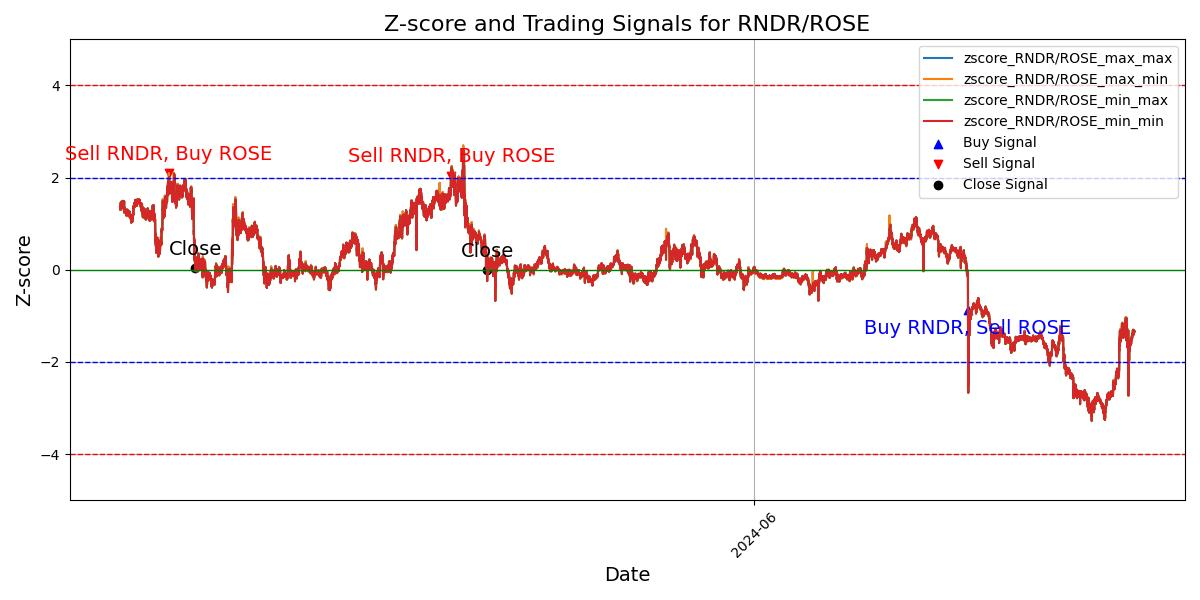

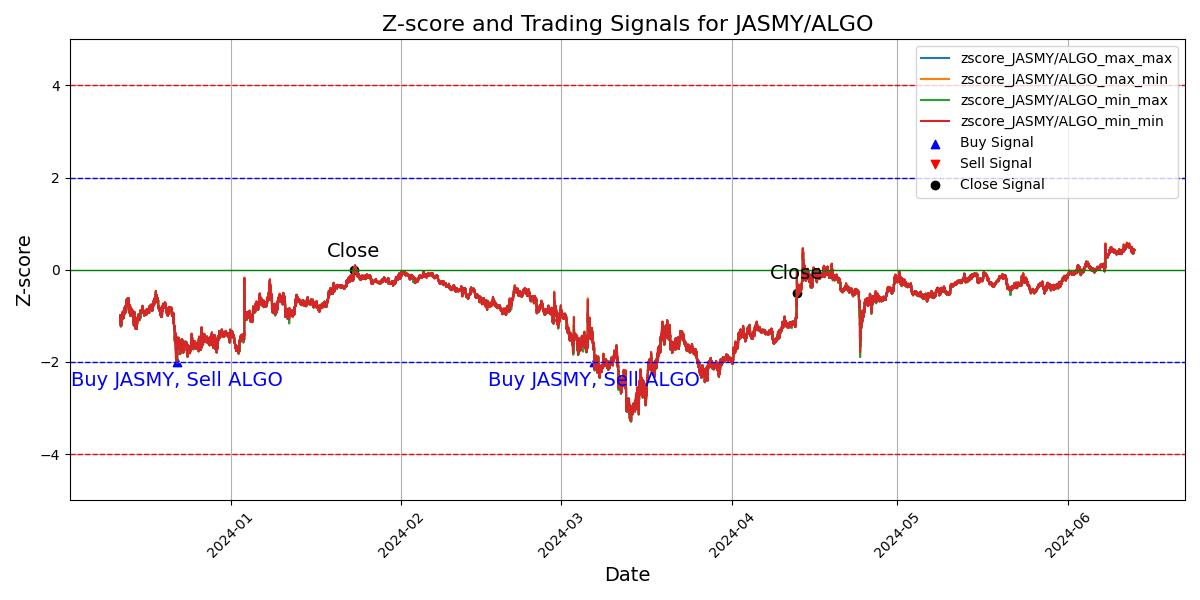

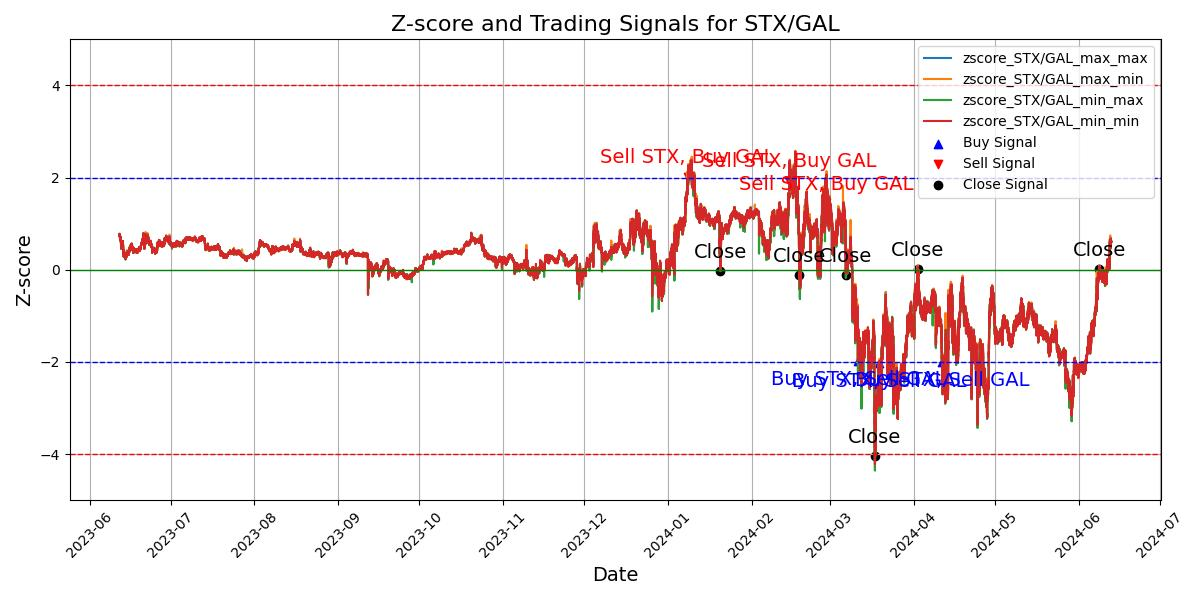

# 4. Backtesting

Now the strategy is defined, and the signals are set, it is time to backtest! All the 3 time period strategies will be backtested in the same way, the only difference is the timer period. The results will be discussed in the Results section. If a trade is still running, but the backtest stops, the trade gets 'refuned', so this will not be calculated as a 'profitable trade' or a 'losing trade'. Again first the backtrade code will be displayed of the 1 month strategy.


1 Month:


In [ ]:
import pandas as pd
import numpy as np
import backtrader as bt
from backtrader.analyzers import DrawDown, TradeAnalyzer
import matplotlib.pyplot as plt

# Load the filtered CSV file for the last month
file_path = 'D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\FinalTrading1MCSV.csv'
final_trading_df = pd.read_csv(file_path, parse_dates=True, index_col=0)

# Print column names to verify
print("Columns in DataFrame:", final_trading_df.columns)

# Replace '/' with '_' in column names
final_trading_df.columns = final_trading_df.columns.str.replace('/', '_')

# Extract signal columns
signal_columns = [col for col in final_trading_df.columns if col.startswith('signal_')]

# Convert signal columns to string type and replace NaN values with 'None'
for col in signal_columns:
    final_trading_df[col] = final_trading_df[col].astype(str).replace('nan', 'None')

# Convert necessary columns to numeric types and replace NaN values
price_columns = [col for col in final_trading_df.columns if col.endswith('_MAX')]
for col in price_columns:
    final_trading_df[col] = pd.to_numeric(final_trading_df[col], errors='coerce')
    final_trading_df[col] = final_trading_df[col].fillna(0)

# Check for Inf values and replace them
final_trading_df.replace([np.inf, -np.inf], np.nan, inplace=True)
final_trading_df.fillna(0, inplace=True)

# Define the trading strategy
class PairTradingStrategy(bt.Strategy):
    params = (('stake', 100),)

    def __init__(self):
        self.orders = {col: None for col in signal_columns}
        self.position_sizes = {col: {'long': 0, 'short': 0} for col in signal_columns}
        self.position_values = {col: {'long': 0, 'short': 0} for col in signal_columns}
        self.opening_prices = {col: {'long': 0, 'short': 0} for col in signal_columns}
        self.trade_directions = {col: None for col in signal_columns}  # Store trade directions
        self.initial_cash = self.broker.get_cash()
        self.nan_detected = False
        self.prev_cash = self.initial_cash
        self.trade_count = 0
        self.profitable_trades = 0
        self.losing_trades = 0
        self.refunded_trades = 0
        self.total_profit = 0  # To store the total profit
        self.daily_returns = []
        self.dates = []  # To store dates for plotting
        self.cumulative_profits = []  # To store cumulative profits over time

    def next(self):
        current_date = self.datas[0].datetime.datetime(0)
        self.dates.append(current_date)  # Append current date for plotting

        for signal_col in signal_columns:
            signal = final_trading_df.at[current_date, signal_col] if current_date in final_trading_df.index else 'None'
            try:
                asset1, asset2 = signal_col.split('_')[1], signal_col.split('_')[2]
            except ValueError:
                continue

            max_price1_col = f'{asset1}_MAX'
            max_price2_col = f'{asset2}_MAX'

            if max_price1_col not in final_trading_df.columns or max_price2_col not in final_trading_df.columns:
                continue

            max_price1 = final_trading_df.at[current_date, max_price1_col]
            max_price2 = final_trading_df.at[current_date, max_price2_col]

            if self.orders[signal_col]:
                continue

            if signal.startswith('Sell') and signal.endswith(f'{asset1}, Buy {asset2}'):
                amount_asset1 = self.params.stake / max_price1
                amount_asset2 = self.params.stake / max_price2
                self.position_sizes[signal_col]['short'] += amount_asset1
                self.position_sizes[signal_col]['long'] += amount_asset2
                self.position_values[signal_col]['short'] += self.params.stake
                self.position_values[signal_col]['long'] += self.params.stake
                self.opening_prices[signal_col]['short'] = max_price1
                self.opening_prices[signal_col]['long'] = max_price2
                self.trade_directions[signal_col] = 'Sell'
                self.broker.add_cash(-self.params.stake * 2)
                print(f"{current_date}: {signal} - Short {asset1} at {max_price1:.7f}, size: {amount_asset1:.7f}, Long {asset2} at {max_price2:.7f}, size: {amount_asset2:.7f}")
                print(f"Date: {current_date}, Cash: {self.broker.get_cash():.7f}")
            elif signal.startswith('Buy') and signal.endswith(f'{asset1}, Sell {asset2}'):
                amount_asset1 = self.params.stake / max_price1
                amount_asset2 = self.params.stake / max_price2
                self.position_sizes[signal_col]['long'] += amount_asset1
                self.position_sizes[signal_col]['short'] += amount_asset2
                self.position_values[signal_col]['long'] += self.params.stake
                self.position_values[signal_col]['short'] += self.params.stake
                self.opening_prices[signal_col]['long'] = max_price1
                self.opening_prices[signal_col]['short'] = max_price2
                self.trade_directions[signal_col] = 'Buy'
                self.broker.add_cash(-self.params.stake * 2)
                print(f"{current_date}: {signal} - Long {asset1} at {max_price1:.7f}, size: {amount_asset1:.7f}, Short {asset2} at {max_price2:.7f}, size: {amount_asset2:.7f}")
                print(f"Date: {current_date}, Cash: {self.broker.get_cash():.7f}")
            elif signal.startswith('Close'):
                long_profit, short_profit = 0, 0
                total_amount_long, total_amount_short = 0, 0
                direction = self.trade_directions[signal_col]

                if direction == 'Buy':
                    if self.position_sizes[signal_col]['long'] != 0:
                        long_close_value = self.position_sizes[signal_col]['long'] * max_price1
                        long_profit = (max_price1 - self.opening_prices[signal_col]['long']) * self.position_sizes[signal_col]['long']
                        total_amount_long = self.params.stake + long_profit
                        self.broker.add_cash(total_amount_long)
                        print(f"{current_date}: {signal} - Closing {asset1} (long) position size: {self.position_sizes[signal_col]['long']:.7f}, Open price: {self.opening_prices[signal_col]['long']:.7f}, Close price: {max_price1:.7f}, Value: {long_close_value:.7f}, Profit: {long_profit:.7f}, Total to add: {total_amount_long:.7f}")
                        self.position_sizes[signal_col]['long'] = 0
                        self.position_values[signal_col]['long'] = 0
                        self.opening_prices[signal_col]['long'] = 0

                    if self.position_sizes[signal_col]['short'] != 0:
                        short_close_value = self.position_sizes[signal_col]['short'] * max_price2
                        short_profit = (self.opening_prices[signal_col]['short'] - max_price2) * self.position_sizes[signal_col]['short']
                        total_amount_short = self.params.stake + short_profit
                        self.broker.add_cash(total_amount_short)
                        print(f"{current_date}: {signal} - Closing {asset2} (short) position size: {self.position_sizes[signal_col]['short']:.7f}, Open price: {self.opening_prices[signal_col]['short']:.7f}, Close price: {max_price2:.7f}, Value: {short_close_value:.7f}, Profit: {short_profit:.7f}, Total to add: {total_amount_short:.7f}")
                        self.position_sizes[signal_col]['short'] = 0
                        self.position_values[signal_col]['short'] = 0
                        self.opening_prices[signal_col]['short'] = 0

                elif direction == 'Sell':
                    if self.position_sizes[signal_col]['long'] != 0:
                        long_close_value = self.position_sizes[signal_col]['long'] * max_price2
                        long_profit = (max_price2 - self.opening_prices[signal_col]['long']) * self.position_sizes[signal_col]['long']
                        total_amount_long = self.params.stake + long_profit
                        self.broker.add_cash(total_amount_long)
                        print(f"{current_date}: {signal} - Closing {asset2} (long) position size: {self.position_sizes[signal_col]['long']:.7f}, Open price: {self.opening_prices[signal_col]['long']:.7f}, Close price: {max_price2:.7f}, Value: {long_close_value:.7f}, Profit: {long_profit:.7f}, Total to add: {total_amount_long:.7f}")
                        self.position_sizes[signal_col]['long'] = 0
                        self.position_values[signal_col]['long'] = 0
                        self.opening_prices[signal_col]['long'] = 0

                    if self.position_sizes[signal_col]['short'] != 0:
                        short_close_value = self.position_sizes[signal_col]['short'] * max_price1
                        short_profit = (self.opening_prices[signal_col]['short'] - max_price1) * self.position_sizes[signal_col]['short']
                        total_amount_short = self.params.stake + short_profit
                        self.broker.add_cash(total_amount_short)
                        print(f"{current_date}: {signal} - Closing {asset1} (short) position size: {self.position_sizes[signal_col]['short']:.7f}, Open price: {self.opening_prices[signal_col]['short']:.7f}, Close price: {max_price1:.7f}, Value: {short_close_value:.7f}, Profit: {short_profit:.7f}, Total to add: {total_amount_short:.7f}")
                        self.position_sizes[signal_col]['short'] = 0
                        self.position_values[signal_col]['short'] = 0
                        self.opening_prices[signal_col]['short'] = 0

                # Calculate overall profit for the pair trade
                total_profit = long_profit + short_profit
                self.total_profit += total_profit  # Accumulate the total profit
                if direction is not None:
                    self.trade_count += 1
                    self.daily_returns.append(total_profit / self.params.stake)
                    self.cumulative_profits.append(self.total_profit)
                    if total_profit > 0:
                        self.profitable_trades += 1
                    else:
                        self.losing_trades += 1

                print(f"{current_date}: Close Positions - Closing positions for {asset1 if direction == 'Buy' else asset2} (long) and {asset2 if direction == 'Buy' else asset1} (short), Total Profit: {total_profit:.7f}")

            # Print current cash after each step if it changes
            current_cash = self.broker.get_cash()
            if self.prev_cash != current_cash:
                print(f"Date: {current_date}, Cash: {current_cash:.7f}")
            self.prev_cash = current_cash

    def stop(self):
        # No need to process remaining open trades in stop, we will handle this after run
        pass

# Initialize Cerebro engine
cerebro = bt.Cerebro()

# Add data feed
data = bt.feeds.PandasData(dataname=final_trading_df)
cerebro.adddata(data)

# Add strategy to Cerebro
cerebro.addstrategy(PairTradingStrategy)

# Set initial cash
cerebro.broker.setcash(100000.0)

# Add analyzers
cerebro.addanalyzer(DrawDown, _name='drawdown')
cerebro.addanalyzer(TradeAnalyzer, _name='trades')

# Run the backtest
print('Starting Portfolio Value: %.7f' % cerebro.broker.getvalue())
strategies = cerebro.run()
strategy = strategies[0]

# Handle any remaining open trades and add refunds after the strategy has completed
total_refund = 0

for signal_col in signal_columns:
    if strategy.position_sizes[signal_col]['long'] != 0 or strategy.position_sizes[signal_col]['short'] != 0:
        total_refund += 200  # For each position still open, add the stake amount back to cash balance
        strategy.refunded_trades += 1
        print(f"End of timeframe: Refunding position for {signal_col}, Refund Amount: 200")

# Add the total refunds to the cash balance and the portfolio value
cerebro.broker.cash += total_refund


# Print the ending cash value and portfolio value after the strategy has finished
ending_cash_value = cerebro.broker.get_cash()
ending_portfolio_value = cerebro.broker.get_value()
print(f"Ending Cash Value after refunds: {ending_cash_value:.7f}")


# Calculate and print additional statistics
drawdown = strategy.analyzers.drawdown.get_analysis()
trade_analysis = strategy.analyzers.trades.get_analysis()

total_trades = strategy.trade_count
profitable_trades = strategy.profitable_trades
losing_trades = strategy.losing_trades
win_rate = (profitable_trades / total_trades) * 100 if total_trades > 0 else 0
roi = (strategy.total_profit / ((profitable_trades + losing_trades) * 200)) * 100 if total_trades != 0 else 0
average_profit_per_trade = strategy.total_profit / total_trades if total_trades != 0 else 0
max_drawdown = drawdown.max.drawdown

# Calculate annualized return
days_in_year = 365  # Trading days in a year
days_traded = (strategy.dates[-1] - strategy.dates[0]).days
annualized_return = ((1 + (roi / 100)) ** (days_in_year / days_traded) - 1) * 100 if days_traded > 0 else 0

print(f"Total Trades: {total_trades}")
print(f"Profitable Trades: {profitable_trades}")
print(f"Losing Trades: {losing_trades}")
print(f"Refunded Trades: {strategy.refunded_trades}")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Return on Investment (ROI): {roi:.7f}%")
print(f"Average Profit per Trade: {average_profit_per_trade:.7f} $")
print(f"Annualized Return: {annualized_return:.7f}%")
print(f"Maximum Drawdown: {max_drawdown:.2f}%")

# Plot cumulative profits over time
plt.figure(figsize=(12, 6))
plt.plot(strategy.dates[:len(strategy.cumulative_profits)], strategy.cumulative_profits, label='Cumulative Profits')
plt.xlabel('Date')
plt.ylabel('Cumulative Profits ($)')
plt.title('Cumulative Profits Over Time')
plt.legend()
plt.grid(True)
plt.show()


How the output looks like during the process:

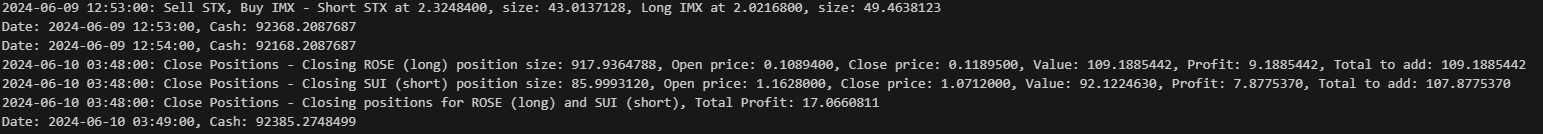

6 Months:

In [ ]:
import pandas as pd
import numpy as np
import backtrader as bt
from backtrader.analyzers import DrawDown, TradeAnalyzer
import matplotlib.pyplot as plt

# Load the filtered CSV file for the last 6 months
file_path = 'D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\FinalTrading6MCSV.csv'
final_trading_df = pd.read_csv(file_path, parse_dates=True, index_col=0)

# Print column names to verify
print("Columns in DataFrame:", final_trading_df.columns)

# Replace '/' with '_' in column names
final_trading_df.columns = final_trading_df.columns.str.replace('/', '_')

# Extract signal columns
signal_columns = [col for col in final_trading_df.columns if col.startswith('signal_')]

# Convert signal columns to string type and replace NaN values with 'None'
for col in signal_columns:
    final_trading_df[col] = final_trading_df[col].astype(str).replace('nan', 'None')

# Convert necessary columns to numeric types and replace NaN values
price_columns = [col for col in final_trading_df.columns if col.endswith('_MAX')]
for col in price_columns:
    final_trading_df[col] = pd.to_numeric(final_trading_df[col], errors='coerce')
    final_trading_df[col] = final_trading_df[col].fillna(0)

# Check for Inf values and replace them
final_trading_df.replace([np.inf, -np.inf], np.nan, inplace=True)
final_trading_df.fillna(0, inplace=True)

# Define the trading strategy
class PairTradingStrategy(bt.Strategy):
    params = (('stake', 100),)

    def __init__(self):
        self.orders = {col: None for col in signal_columns}
        self.position_sizes = {col: {'long': 0, 'short': 0} for col in signal_columns}
        self.position_values = {col: {'long': 0, 'short': 0} for col in signal_columns}
        self.opening_prices = {col: {'long': 0, 'short': 0} for col in signal_columns}
        self.trade_directions = {col: None for col in signal_columns}  # Store trade directions
        self.initial_cash = self.broker.get_cash()
        self.nan_detected = False
        self.prev_cash = self.initial_cash
        self.trade_count = 0
        self.profitable_trades = 0
        self.losing_trades = 0
        self.refunded_trades = 0
        self.total_profit = 0  # To store the total profit
        self.daily_returns = []
        self.dates = []  # To store dates for plotting
        self.cumulative_profits = []  # To store cumulative profits over time

    def next(self):
        current_date = self.datas[0].datetime.datetime(0)
        self.dates.append(current_date)  # Append current date for plotting

        for signal_col in signal_columns:
            signal = final_trading_df.at[current_date, signal_col] if current_date in final_trading_df.index else 'None'
            try:
                asset1, asset2 = signal_col.split('_')[1], signal_col.split('_')[2]
            except ValueError:
                continue

            max_price1_col = f'{asset1}_MAX'
            max_price2_col = f'{asset2}_MAX'

            if max_price1_col not in final_trading_df.columns or max_price2_col not in final_trading_df.columns:
                continue

            max_price1 = final_trading_df.at[current_date, max_price1_col]
            max_price2 = final_trading_df.at[current_date, max_price2_col]

            if self.orders[signal_col]:
                continue

            if signal.startswith('Sell') and signal.endswith(f'{asset1}, Buy {asset2}'):
                amount_asset1 = self.params.stake / max_price1
                amount_asset2 = self.params.stake / max_price2
                self.position_sizes[signal_col]['short'] += amount_asset1
                self.position_sizes[signal_col]['long'] += amount_asset2
                self.position_values[signal_col]['short'] += self.params.stake
                self.position_values[signal_col]['long'] += self.params.stake
                self.opening_prices[signal_col]['short'] = max_price1
                self.opening_prices[signal_col]['long'] = max_price2
                self.trade_directions[signal_col] = 'Sell'
                self.broker.add_cash(-self.params.stake * 2)
                print(f"{current_date}: {signal} - Short {asset1} at {max_price1:.7f}, size: {amount_asset1:.7f}, Long {asset2} at {max_price2:.7f}, size: {amount_asset2:.7f}")
                print(f"Date: {current_date}, Cash: {self.broker.get_cash():.7f}")
            elif signal.startswith('Buy') and signal.endswith(f'{asset1}, Sell {asset2}'):
                amount_asset1 = self.params.stake / max_price1
                amount_asset2 = self.params.stake / max_price2
                self.position_sizes[signal_col]['long'] += amount_asset1
                self.position_sizes[signal_col]['short'] += amount_asset2
                self.position_values[signal_col]['long'] += self.params.stake
                self.position_values[signal_col]['short'] += self.params.stake
                self.opening_prices[signal_col]['long'] = max_price1
                self.opening_prices[signal_col]['short'] = max_price2
                self.trade_directions[signal_col] = 'Buy'
                self.broker.add_cash(-self.params.stake * 2)
                print(f"{current_date}: {signal} - Long {asset1} at {max_price1:.7f}, size: {amount_asset1:.7f}, Short {asset2} at {max_price2:.7f}, size: {amount_asset2:.7f}")
                print(f"Date: {current_date}, Cash: {self.broker.get_cash():.7f}")
            elif signal.startswith('Close'):
                long_profit, short_profit = 0, 0
                total_amount_long, total_amount_short = 0, 0
                direction = self.trade_directions[signal_col]

                if direction == 'Buy':
                    if self.position_sizes[signal_col]['long'] != 0:
                        long_close_value = self.position_sizes[signal_col]['long'] * max_price1
                        long_profit = (max_price1 - self.opening_prices[signal_col]['long']) * self.position_sizes[signal_col]['long']
                        total_amount_long = self.params.stake + long_profit
                        self.broker.add_cash(total_amount_long)
                        print(f"{current_date}: {signal} - Closing {asset1} (long) position size: {self.position_sizes[signal_col]['long']:.7f}, Open price: {self.opening_prices[signal_col]['long']:.7f}, Close price: {max_price1:.7f}, Value: {long_close_value:.7f}, Profit: {long_profit:.7f}, Total to add: {total_amount_long:.7f}")
                        self.position_sizes[signal_col]['long'] = 0
                        self.position_values[signal_col]['long'] = 0
                        self.opening_prices[signal_col]['long'] = 0

                    if self.position_sizes[signal_col]['short'] != 0:
                        short_close_value = self.position_sizes[signal_col]['short'] * max_price2
                        short_profit = (self.opening_prices[signal_col]['short'] - max_price2) * self.position_sizes[signal_col]['short']
                        total_amount_short = self.params.stake + short_profit
                        self.broker.add_cash(total_amount_short)
                        print(f"{current_date}: {signal} - Closing {asset2} (short) position size: {self.position_sizes[signal_col]['short']:.7f}, Open price: {self.opening_prices[signal_col]['short']:.7f}, Close price: {max_price2:.7f}, Value: {short_close_value:.7f}, Profit: {short_profit:.7f}, Total to add: {total_amount_short:.7f}")
                        self.position_sizes[signal_col]['short'] = 0
                        self.position_values[signal_col]['short'] = 0
                        self.opening_prices[signal_col]['short'] = 0

                elif direction == 'Sell':
                    if self.position_sizes[signal_col]['long'] != 0:
                        long_close_value = self.position_sizes[signal_col]['long'] * max_price2
                        long_profit = (max_price2 - self.opening_prices[signal_col]['long']) * self.position_sizes[signal_col]['long']
                        total_amount_long = self.params.stake + long_profit
                        self.broker.add_cash(total_amount_long)
                        print(f"{current_date}: {signal} - Closing {asset2} (long) position size: {self.position_sizes[signal_col]['long']:.7f}, Open price: {self.opening_prices[signal_col]['long']:.7f}, Close price: {max_price2:.7f}, Value: {long_close_value:.7f}, Profit: {long_profit:.7f}, Total to add: {total_amount_long:.7f}")
                        self.position_sizes[signal_col]['long'] = 0
                        self.position_values[signal_col]['long'] = 0
                        self.opening_prices[signal_col]['long'] = 0

                    if self.position_sizes[signal_col]['short'] != 0:
                        short_close_value = self.position_sizes[signal_col]['short'] * max_price1
                        short_profit = (self.opening_prices[signal_col]['short'] - max_price1) * self.position_sizes[signal_col]['short']
                        total_amount_short = self.params.stake + short_profit
                        self.broker.add_cash(total_amount_short)
                        print(f"{current_date}: {signal} - Closing {asset1} (short) position size: {self.position_sizes[signal_col]['short']:.7f}, Open price: {self.opening_prices[signal_col]['short']:.7f}, Close price: {max_price1:.7f}, Value: {short_close_value:.7f}, Profit: {short_profit:.7f}, Total to add: {total_amount_short:.7f}")
                        self.position_sizes[signal_col]['short'] = 0
                        self.position_values[signal_col]['short'] = 0
                        self.opening_prices[signal_col]['short'] = 0

                # Calculate overall profit for the pair trade
                total_profit = long_profit + short_profit
                self.total_profit += total_profit  # Accumulate the total profit
                if direction is not None:
                    self.trade_count += 1
                    self.daily_returns.append(total_profit / self.params.stake)
                    self.cumulative_profits.append(self.total_profit)
                    if total_profit > 0:
                        self.profitable_trades += 1
                    else:
                        self.losing_trades += 1

                print(f"{current_date}: Close Positions - Closing positions for {asset1 if direction == 'Buy' else asset2} (long) and {asset2 if direction == 'Buy' else asset1} (short), Total Profit: {total_profit:.7f}")

            # Print current cash after each step if it changes
            current_cash = self.broker.get_cash()
            if self.prev_cash != current_cash:
                print(f"Date: {current_date}, Cash: {current_cash:.7f}")
            self.prev_cash = current_cash

    def stop(self):
        # No need to process remaining open trades in stop, we will handle this after run
        pass

# Initialize Cerebro engine
cerebro = bt.Cerebro()

# Add data feed
data = bt.feeds.PandasData(dataname=final_trading_df)
cerebro.adddata(data)

# Add strategy to Cerebro
cerebro.addstrategy(PairTradingStrategy)

# Set initial cash
cerebro.broker.setcash(100000.0)

# Add analyzers
cerebro.addanalyzer(DrawDown, _name='drawdown')
cerebro.addanalyzer(TradeAnalyzer, _name='trades')

# Run the backtest
print('Starting Portfolio Value: %.7f' % cerebro.broker.getvalue())
strategies = cerebro.run()
strategy = strategies[0]

# Handle any remaining open trades and add refunds after the strategy has completed
total_refund = 0

for signal_col in signal_columns:
    if strategy.position_sizes[signal_col]['long'] != 0 or strategy.position_sizes[signal_col]['short'] != 0:
        total_refund += 200  # For each position still open, add the stake amount back to cash balance
        strategy.refunded_trades += 1
        print(f"End of timeframe: Refunding position for {signal_col}, Refund Amount: 200")

# Add the total refunds to the cash balance and the portfolio value
cerebro.broker.cash += total_refund

print(f"Final Cash after refunds: {cerebro.broker.get_cash():.7f}")

# Print the ending cash value and portfolio value after the strategy has finished
ending_cash_value = cerebro.broker.get_cash()
ending_portfolio_value = cerebro.broker.get_value()
print(f"Ending Cash Value after refunds: {ending_cash_value:.7f}")
print(f"Ending Portfolio Value: {ending_portfolio_value:.7f}")

# Calculate and print additional statistics
drawdown = strategy.analyzers.drawdown.get_analysis()
trade_analysis = strategy.analyzers.trades.get_analysis()

total_trades = strategy.trade_count
profitable_trades = strategy.profitable_trades
losing_trades = strategy.losing_trades
win_rate = (profitable_trades / total_trades) * 100 if total_trades > 0 else 0
roi = (strategy.total_profit / ((profitable_trades + losing_trades) * 200)) * 100 if total_trades != 0 else 0
average_profit_per_trade = strategy.total_profit / total_trades if total_trades != 0 else 0
max_drawdown = drawdown.max.drawdown

# Calculate annualized return
days_in_year = 365  # Trading days in a year
days_traded = (strategy.dates[-1] - strategy.dates[0]).days
annualized_return = ((1 + (roi / 100)) ** (days_in_year / days_traded) - 1) * 100 if days_traded > 0 else 0

print(f"Total Trades: {total_trades}")
print(f"Profitable Trades: {profitable_trades}")
print(f"Losing Trades: {losing_trades}")
print(f"Refunded Trades: {strategy.refunded_trades}")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Return on Investment (ROI): {roi:.7f}%")
print(f"Average Profit per Trade: {average_profit_per_trade:.7f} $")
print(f"Annualized Return: {annualized_return:.7f}%")
print(f"Maximum Drawdown: {max_drawdown:.2f}%")

# Plot cumulative profits over time
plt.figure(figsize=(12, 6))
plt.plot(strategy.dates[:len(strategy.cumulative_profits)], strategy.cumulative_profits, label='Cumulative Profits')
plt.xlabel('Date')
plt.ylabel('Cumulative Profits ($)')
plt.title('Cumulative Profits Over Time')
plt.legend()
plt.grid(True)
plt.show()


How the output looks like during the process:

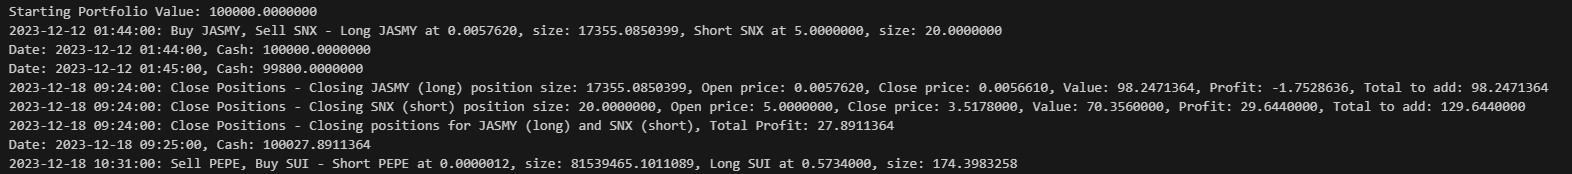

12 Months:

In [ ]:
import pandas as pd
import numpy as np
import backtrader as bt
from backtrader.analyzers import DrawDown, TradeAnalyzer
import matplotlib.pyplot as plt

# Load the filtered CSV file for the last 12 months
file_path = 'D:\\Users\\pctim\\AppData\\Local\\Programs\\Python\\Python311\\Scripts\\FinalTrading12MCSV.csv'
final_trading_df = pd.read_csv(file_path, parse_dates=True, index_col=0)

# Print column names to verify
print("Columns in DataFrame:", final_trading_df.columns)

# Replace '/' with '_' in column names
final_trading_df.columns = final_trading_df.columns.str.replace('/', '_')

# Extract signal columns
signal_columns = [col for col in final_trading_df.columns if col.startswith('signal_')]

# Convert signal columns to string type and replace NaN values with 'None'
for col in signal_columns:
    final_trading_df[col] = final_trading_df[col].astype(str).replace('nan', 'None')

# Convert necessary columns to numeric types and replace NaN values
price_columns = [col for col in final_trading_df.columns if col.endswith('_MAX')]
for col in price_columns:
    final_trading_df[col] = pd.to_numeric(final_trading_df[col], errors='coerce')
    final_trading_df[col] = final_trading_df[col].fillna(0)

# Check for Inf values and replace them
final_trading_df.replace([np.inf, -np.inf], np.nan, inplace=True)
final_trading_df.fillna(0, inplace=True)

# Define the trading strategy
class PairTradingStrategy(bt.Strategy):
    params = (('stake', 100),)

    def __init__(self):
        self.orders = {col: None for col in signal_columns}
        self.position_sizes = {col: {'long': 0, 'short': 0} for col in signal_columns}
        self.position_values = {col: {'long': 0, 'short': 0} for col in signal_columns}
        self.opening_prices = {col: {'long': 0, 'short': 0} for col in signal_columns}
        self.trade_directions = {col: None for col in signal_columns}  # Store trade directions
        self.initial_cash = self.broker.get_cash()
        self.nan_detected = False
        self.prev_cash = self.initial_cash
        self.trade_count = 0
        self.profitable_trades = 0
        self.losing_trades = 0
        self.refunded_trades = 0
        self.total_profit = 0  # To store the total profit
        self.daily_returns = []
        self.dates = []  # To store dates for plotting
        self.cumulative_profits = []  # To store cumulative profits over time

    def next(self):
        current_date = self.datas[0].datetime.datetime(0)
        self.dates.append(current_date)  # Append current date for plotting

        for signal_col in signal_columns:
            signal = final_trading_df.at[current_date, signal_col] if current_date in final_trading_df.index else 'None'
            try:
                asset1, asset2 = signal_col.split('_')[1], signal_col.split('_')[2]
            except ValueError:
                continue

            max_price1_col = f'{asset1}_MAX'
            max_price2_col = f'{asset2}_MAX'

            if max_price1_col not in final_trading_df.columns or max_price2_col not in final_trading_df.columns:
                continue

            max_price1 = final_trading_df.at[current_date, max_price1_col]
            max_price2 = final_trading_df.at[current_date, max_price2_col]

            if self.orders[signal_col]:
                continue

            if signal.startswith('Sell') and signal.endswith(f'{asset1}, Buy {asset2}'):
                amount_asset1 = self.params.stake / max_price1
                amount_asset2 = self.params.stake / max_price2
                self.position_sizes[signal_col]['short'] += amount_asset1
                self.position_sizes[signal_col]['long'] += amount_asset2
                self.position_values[signal_col]['short'] += self.params.stake
                self.position_values[signal_col]['long'] += self.params.stake
                self.opening_prices[signal_col]['short'] = max_price1
                self.opening_prices[signal_col]['long'] = max_price2
                self.trade_directions[signal_col] = 'Sell'
                self.broker.add_cash(-self.params.stake * 2)
                print(f"{current_date}: {signal} - Short {asset1} at {max_price1:.7f}, size: {amount_asset1:.7f}, Long {asset2} at {max_price2:.7f}, size: {amount_asset2:.7f}")
                print(f"Date: {current_date}, Cash: {self.broker.get_cash():.7f}")
            elif signal.startswith('Buy') and signal.endswith(f'{asset1}, Sell {asset2}'):
                amount_asset1 = self.params.stake / max_price1
                amount_asset2 = self.params.stake / max_price2
                self.position_sizes[signal_col]['long'] += amount_asset1
                self.position_sizes[signal_col]['short'] += amount_asset2
                self.position_values[signal_col]['long'] += self.params.stake
                self.position_values[signal_col]['short'] += self.params.stake
                self.opening_prices[signal_col]['long'] = max_price1
                self.opening_prices[signal_col]['short'] = max_price2
                self.trade_directions[signal_col] = 'Buy'
                self.broker.add_cash(-self.params.stake * 2)
                print(f"{current_date}: {signal} - Long {asset1} at {max_price1:.7f}, size: {amount_asset1:.7f}, Short {asset2} at {max_price2:.7f}, size: {amount_asset2:.7f}")
                print(f"Date: {current_date}, Cash: {self.broker.get_cash():.7f}")
            elif signal.startswith('Close'):
                long_profit, short_profit = 0, 0
                total_amount_long, total_amount_short = 0, 0
                direction = self.trade_directions[signal_col]

                if direction == 'Buy':
                    if self.position_sizes[signal_col]['long'] != 0:
                        long_close_value = self.position_sizes[signal_col]['long'] * max_price1
                        long_profit = (max_price1 - self.opening_prices[signal_col]['long']) * self.position_sizes[signal_col]['long']
                        total_amount_long = self.params.stake + long_profit
                        self.broker.add_cash(total_amount_long)
                        print(f"{current_date}: {signal} - Closing {asset1} (long) position size: {self.position_sizes[signal_col]['long']:.7f}, Open price: {self.opening_prices[signal_col]['long']:.7f}, Close price: {max_price1:.7f}, Value: {long_close_value:.7f}, Profit: {long_profit:.7f}, Total to add: {total_amount_long:.7f}")
                        self.position_sizes[signal_col]['long'] = 0
                        self.position_values[signal_col]['long'] = 0
                        self.opening_prices[signal_col]['long'] = 0

                    if self.position_sizes[signal_col]['short'] != 0:
                        short_close_value = self.position_sizes[signal_col]['short'] * max_price2
                        short_profit = (self.opening_prices[signal_col]['short'] - max_price2) * self.position_sizes[signal_col]['short']
                        total_amount_short = self.params.stake + short_profit
                        self.broker.add_cash(total_amount_short)
                        print(f"{current_date}: {signal} - Closing {asset2} (short) position size: {self.position_sizes[signal_col]['short']:.7f}, Open price: {self.opening_prices[signal_col]['short']:.7f}, Close price: {max_price2:.7f}, Value: {short_close_value:.7f}, Profit: {short_profit:.7f}, Total to add: {total_amount_short:.7f}")
                        self.position_sizes[signal_col]['short'] = 0
                        self.position_values[signal_col]['short'] = 0
                        self.opening_prices[signal_col]['short'] = 0

                elif direction == 'Sell':
                    if self.position_sizes[signal_col]['long'] != 0:
                        long_close_value = self.position_sizes[signal_col]['long'] * max_price2
                        long_profit = (max_price2 - self.opening_prices[signal_col]['long']) * self.position_sizes[signal_col]['long']
                        total_amount_long = self.params.stake + long_profit
                        self.broker.add_cash(total_amount_long)
                        print(f"{current_date}: {signal} - Closing {asset2} (long) position size: {self.position_sizes[signal_col]['long']:.7f}, Open price: {self.opening_prices[signal_col]['long']:.7f}, Close price: {max_price2:.7f}, Value: {long_close_value:.7f}, Profit: {long_profit:.7f}, Total to add: {total_amount_long:.7f}")
                        self.position_sizes[signal_col]['long'] = 0
                        self.position_values[signal_col]['long'] = 0
                        self.opening_prices[signal_col]['long'] = 0

                    if self.position_sizes[signal_col]['short'] != 0:
                        short_close_value = self.position_sizes[signal_col]['short'] * max_price1
                        short_profit = (self.opening_prices[signal_col]['short'] - max_price1) * self.position_sizes[signal_col]['short']
                        total_amount_short = self.params.stake + short_profit
                        self.broker.add_cash(total_amount_short)
                        print(f"{current_date}: {signal} - Closing {asset1} (short) position size: {self.position_sizes[signal_col]['short']:.7f}, Open price: {self.opening_prices[signal_col]['short']:.7f}, Close price: {max_price1:.7f}, Value: {short_close_value:.7f}, Profit: {short_profit:.7f}, Total to add: {total_amount_short:.7f}")
                        self.position_sizes[signal_col]['short'] = 0
                        self.position_values[signal_col]['short'] = 0
                        self.opening_prices[signal_col]['short'] = 0

                # Calculate overall profit for the pair trade
                total_profit = long_profit + short_profit
                self.total_profit += total_profit  # Accumulate the total profit
                if direction is not None:
                    self.trade_count += 1
                    self.daily_returns.append(total_profit / self.params.stake)
                    self.cumulative_profits.append(self.total_profit)
                    if total_profit > 0:
                        self.profitable_trades += 1
                    else:
                        self.losing_trades += 1

                print(f"{current_date}: Close Positions - Closing positions for {asset1 if direction == 'Buy' else asset2} (long) and {asset2 if direction == 'Buy' else asset1} (short), Total Profit: {total_profit:.7f}")

            # Print current cash after each step if it changes
            current_cash = self.broker.get_cash()
            if self.prev_cash != current_cash:
                print(f"Date: {current_date}, Cash: {current_cash:.7f}")
            self.prev_cash = current_cash

    def stop(self):
        # No need to process remaining open trades in stop, we will handle this after run
        pass

# Initialize Cerebro engine
cerebro = bt.Cerebro()

# Add data feed
data = bt.feeds.PandasData(dataname=final_trading_df)
cerebro.adddata(data)

# Add strategy to Cerebro
cerebro.addstrategy(PairTradingStrategy)

# Set initial cash
cerebro.broker.setcash(100000.0)

# Add analyzers
cerebro.addanalyzer(DrawDown, _name='drawdown')
cerebro.addanalyzer(TradeAnalyzer, _name='trades')

# Run the backtest
print('Starting Portfolio Value: %.7f' % cerebro.broker.getvalue())
strategies = cerebro.run()
strategy = strategies[0]

# Handle any remaining open trades and add refunds after the strategy has completed
total_refund = 0

for signal_col in signal_columns:
    if strategy.position_sizes[signal_col]['long'] != 0 or strategy.position_sizes[signal_col]['short'] != 0:
        total_refund += 200  # For each position still open, add the stake amount back to cash balance
        strategy.refunded_trades += 1
        print(f"End of timeframe: Refunding position for {signal_col}, Refund Amount: 200")

# Add the total refunds to the cash balance and the portfolio value
cerebro.broker.cash += total_refund

print(f"Final Cash after refunds: {cerebro.broker.get_cash():.7f}")

# Print the ending cash value and portfolio value after the strategy has finished
ending_cash_value = cerebro.broker.get_cash()
ending_portfolio_value = cerebro.broker.get_value()
print(f"Ending Cash Value after refunds: {ending_cash_value:.7f}")
print(f"Ending Portfolio Value: {ending_portfolio_value:.7f}")

# Calculate and print additional statistics
drawdown = strategy.analyzers.drawdown.get_analysis()
trade_analysis = strategy.analyzers.trades.get_analysis()

total_trades = strategy.trade_count
profitable_trades = strategy.profitable_trades
losing_trades = strategy.losing_trades
win_rate = (profitable_trades / total_trades) * 100 if total_trades > 0 else 0
roi = (strategy.total_profit / ((profitable_trades + losing_trades) * 200)) * 100 if total_trades != 0 else 0
average_profit_per_trade = strategy.total_profit / total_trades if total_trades != 0 else 0
max_drawdown = drawdown.max.drawdown



print(f"Total Trades: {total_trades}")
print(f"Profitable Trades: {profitable_trades}")
print(f"Losing Trades: {losing_trades}")
print(f"Refunded Trades: {strategy.refunded_trades}")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Return on Investment (ROI): {roi:.7f}%")
print(f"Average Profit per Trade: {average_profit_per_trade:.7f} $")
print(f"Maximum Drawdown: {max_drawdown:.2f}%")

# Plot cumulative profits over time
plt.figure(figsize=(12, 6))
plt.plot(strategy.dates[:len(strategy.cumulative_profits)], strategy.cumulative_profits, label='Cumulative Profits')
plt.xlabel('Date')
plt.ylabel('Cumulative Profits ($)')
plt.title('Cumulative Profits Over Time')
plt.legend()
plt.grid(True)
plt.show()


How the output looks like during the process:

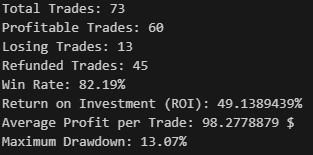

# 5. Results

Results 1 Month:

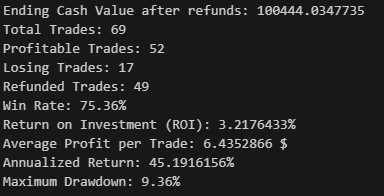 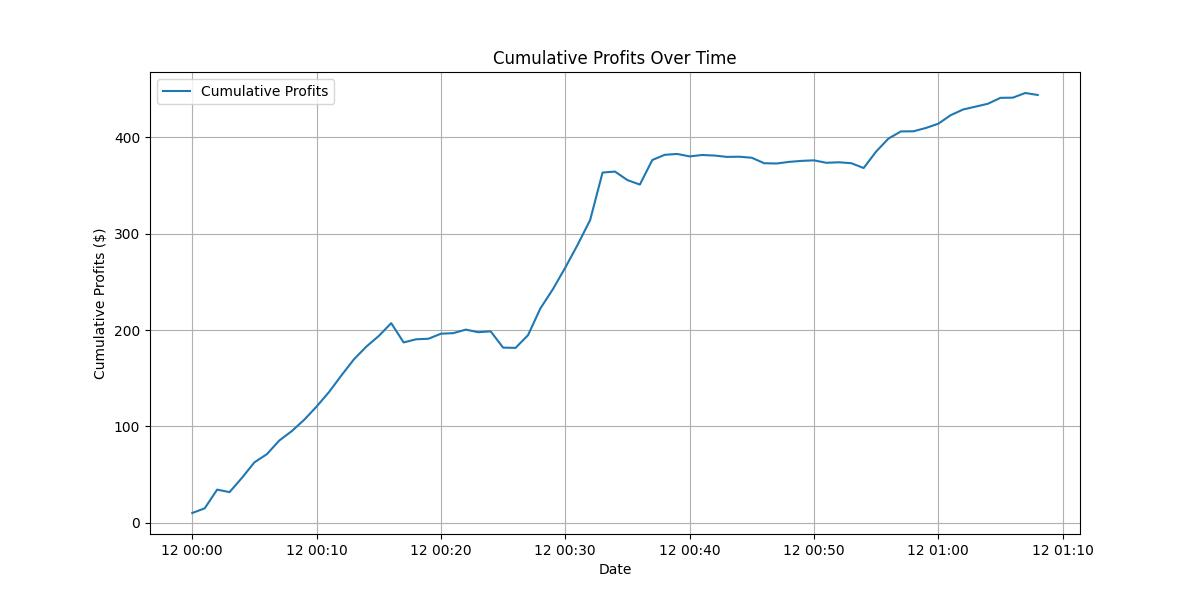

Results 6 Months:

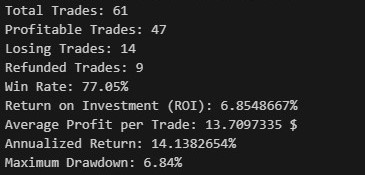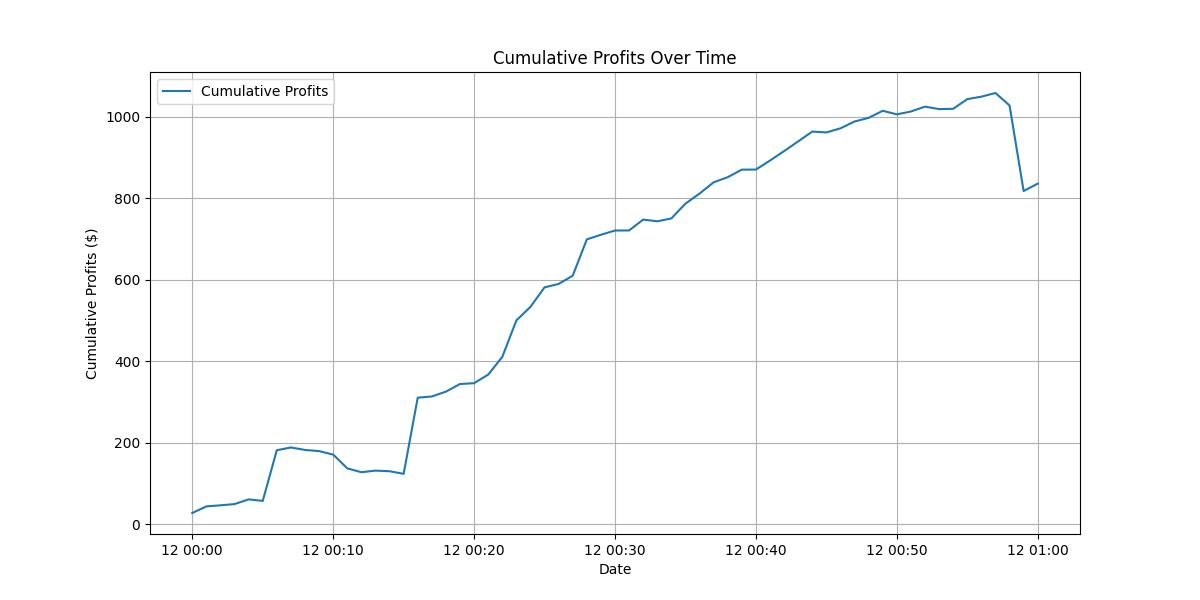

Results 12 Months:

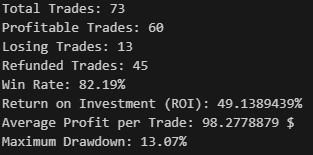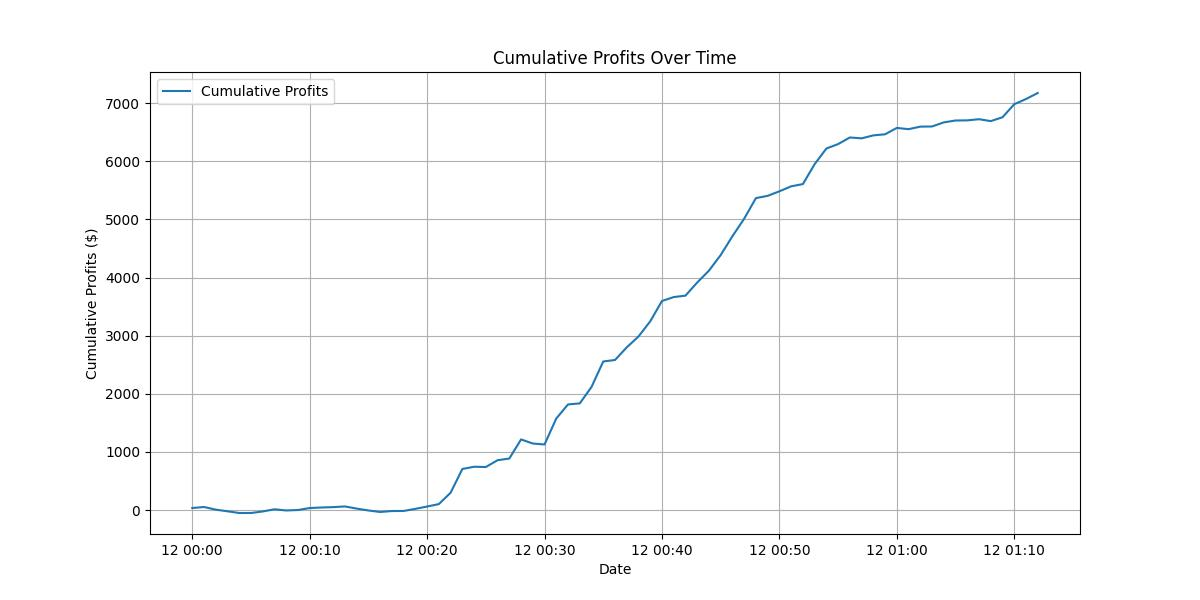

Overall conclusion:

All the models performed profitable results, but the winrate and profit per trade increases when the cointegrated relationship is longer, so 12 performs best then 6 months and finally 1 month. The ROI of almost 50% for the 12 months strategy is really impressive and shows that this strategy is capable of getting good results within the crypto market.

For any further questions pls contact me.